In [1]:
# DataHandler Class for Dataset Splitting and Saving

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

class DataHandler:
    def __init__(self, file_path, label_column="Label"):
        self.file_path = file_path
        self.label_column = label_column
        self.df = None
        self.labeled_df = None
        self.unlabeled_df = None
        self.unlabeled_train_df = None
        self.unlabeled_test_df = None
        self.train_labels = None
        self.test_labels = None

    def load_dataset(self):
        self.df = pd.read_csv(self.file_path)
        print(f"Dataset loaded successfully. Shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")

    def split_labeled_unlabeled(self, labeled_fraction=0.05):
        np.random.seed(42)
        self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)
        self.labeled_df = self.df.sample(frac=labeled_fraction, random_state=42)
        self.unlabeled_df = self.df.drop(self.labeled_df.index)
        print(f"Labeled Data Shape: {self.labeled_df.shape}")
        print(f"Unlabeled Data Shape: {self.unlabeled_df.shape}")

    def split_unlabeled_train_test(self, test_size=0.10):
        original_labels = self.unlabeled_df[self.label_column]
        unlabeled_df_no_label = self.unlabeled_df.drop(columns=[self.label_column])

        self.unlabeled_train_df, self.unlabeled_test_df, self.train_labels, self.test_labels = train_test_split(
            unlabeled_df_no_label, original_labels, test_size=test_size, random_state=42
        )

        print(f"Unlabeled Train Shape: {self.unlabeled_train_df.shape}")
        print(f"Unlabeled Test Shape: {self.unlabeled_test_df.shape}")
        return self.unlabeled_train_df, self.unlabeled_test_df, self.train_labels, self.test_labels

    def save_datasets(self):
        self.labeled_df.to_csv("labeled_data.csv", index=False)
        self.unlabeled_train_df.to_csv("unlabeled_train_data.csv", index=False)
        self.unlabeled_test_df.to_csv("unlabeled_test_data.csv", index=False)
        self.train_labels.to_csv("unlabeled_train_true_labels.csv", index=False)
        self.test_labels.to_csv("unlabeled_test_true_labels.csv", index=False)
        print("Datasets saved successfully!")

    def prepare_labeled_data_for_training(self, validation_split=0.20):
        X = self.labeled_df.drop(columns=[self.label_column])
        y = self.labeled_df[self.label_column]
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )
        print(f"Training Data Shape: {X_train.shape}")
        print(f"Validation Data Shape: {X_val.shape}")
        return X_train, X_val, y_train, y_val


In [2]:
# TeacherModel Class

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

class TeacherModel:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.models = self._initialize_models()
        self.trained_models = {}

    def _initialize_models(self):
        return {
            "XGBoost": XGBClassifier(eval_metric='logloss'),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
            "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
        }

    def train_with_cross_validation(self, folds=10):
        best_scores = {}
        for name, model in self.models.items():
            scores = cross_val_score(model, self.X_train, self.y_train, cv=folds, scoring='accuracy')
            avg_score = scores.mean()
            best_scores[name] = avg_score
            print(f"{name} - Avg Accuracy (10-fold CV): {avg_score:.4f}")

            model.fit(self.X_train, self.y_train)
            self.trained_models[name] = model
        return best_scores

    def generate_pseudo_labels(self, unlabeled_df, model_name):
        model = self.trained_models.get(model_name)
        if model:
            preds = model.predict(unlabeled_df)
            return preds
        else:
            print(f"Model {model_name} not found!")
            return None


In [3]:
# StudentModel Class

import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

class StudentModel:
    def __init__(self, pseudo_labels_df, true_labels):
        self.X_train = pseudo_labels_df  # Features from pseudo labels
        self.y_train = true_labels       # True labels for the test set
        self.models = self._initialize_models()
        self.trained_models = {}
        self.results = []
        self.best_model = None
        self.best_model_name = None
        self.best_score = 0

    def _initialize_models(self):
        return {
            "XGBoost": XGBClassifier(eval_metric='logloss'),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
            "Decision Tree": DecisionTreeClassifier(random_state=42),
            "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
            "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
        }

    def train_and_evaluate(self, X_test, y_test, teacher_model_name):

        for name, model in self.models.items():
            # 10-Fold Cross-Validation on pseudo-labeled data
            cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=10, scoring='accuracy')
            avg_cv_score = cv_scores.mean()

            # Train model
            model.fit(self.X_train, self.y_train)
            self.trained_models[name] = model

            # Predictions on test data
            y_pred = model.predict(X_test)

            # Calculate Evaluation Metrics
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            # Store results
            self.results.append({
                "Teacher Model": teacher_model_name,
                "Student Model": name,
                "Cross-Validation Accuracy": avg_cv_score,
                "Test Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1
            })

            # Save the best model based on accuracy
            if acc > self.best_score:
                self.best_score = acc
                self.best_model = model
                self.best_model_name = name

            # Generate and plot confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
            plt.xlabel("Predicted Labels")
            plt.ylabel("True Labels")
            plt.title(f"Confusion Matrix ({teacher_model_name} → {name})")
            plt.show()

        print(f"Training complete for Teacher Model: {teacher_model_name}")

    def save_results(self, teacher_model_name):
        results_df = pd.DataFrame(self.results)

        # Ensure the results directory exists
        os.makedirs("results", exist_ok=True)

        # Define the file path
        file_path = "student_model_results.csv"

        # If the file already exists, append new results without overwriting
        if os.path.exists(file_path):
            results_df.to_csv(file_path, mode='a', header=False, index=False)
        else:
            results_df.to_csv(file_path, index=False)

        print(f"Results for {teacher_model_name} saved successfully!")

    def get_best_student_model(self):
        return self.best_model_name, self.best_score


Dataset loaded successfully. Shape: (211043, 31)
Columns: ['proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'http_trans_depth', 'http_method', 'http_version', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'Label']
Labeled Data Shape: (10552, 31)
Unlabeled Data Shape: (200491, 31)
Unlabeled Train Shape: (180441, 30)
Unlabeled Test Shape: (20050, 30)
Datasets saved successfully!
Training Data Shape: (8441, 30)
Validation Data Shape: (2111, 30)
XGBoost - Avg Accuracy (10-fold CV): 0.9964
Random Forest - Avg Accuracy (10-fold CV): 0.9968
Decision Tree - Avg Accuracy (10-fold CV): 0.9948
Bagging - Avg Accuracy (10-fold CV): 0.9954
AdaBoost - Avg Accuracy (10-fold CV): 0.9852


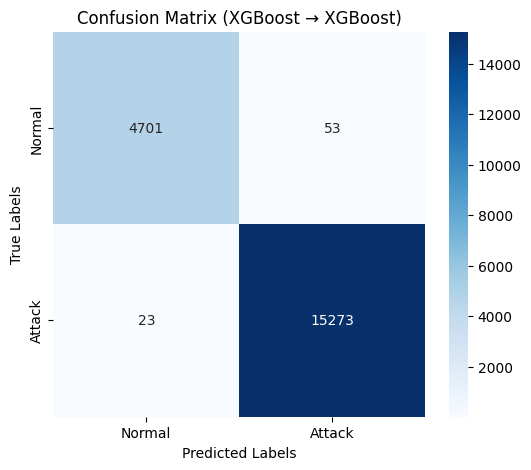

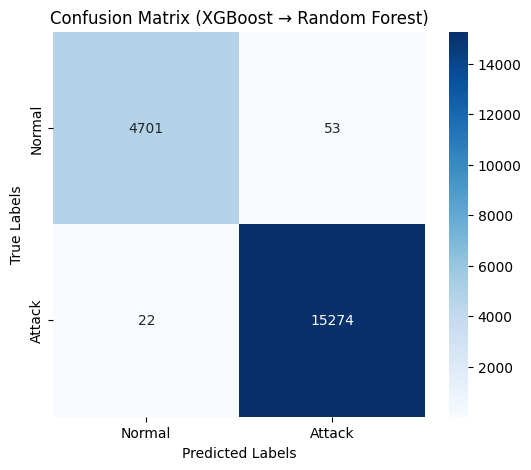

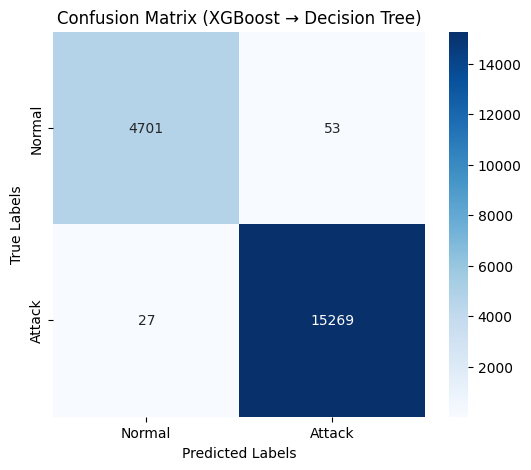

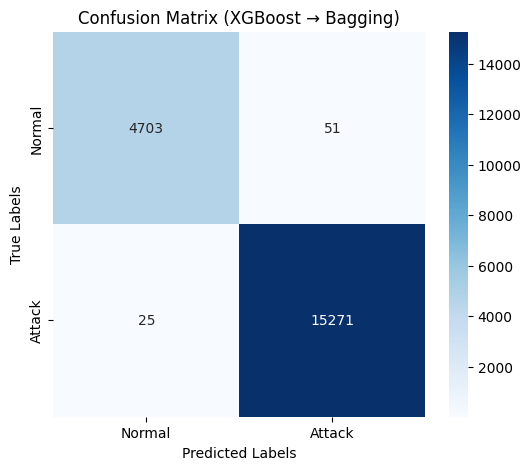

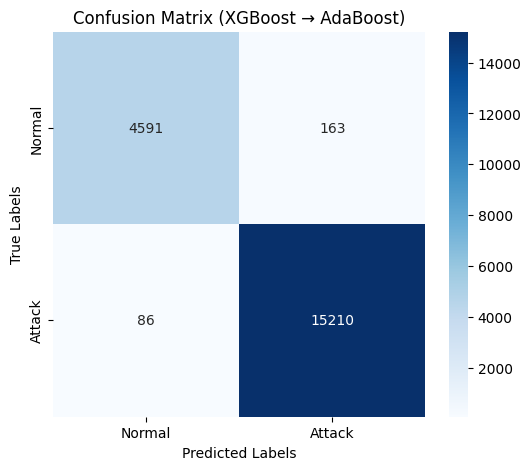

Training complete for Teacher Model: XGBoost
Results for XGBoost saved successfully!


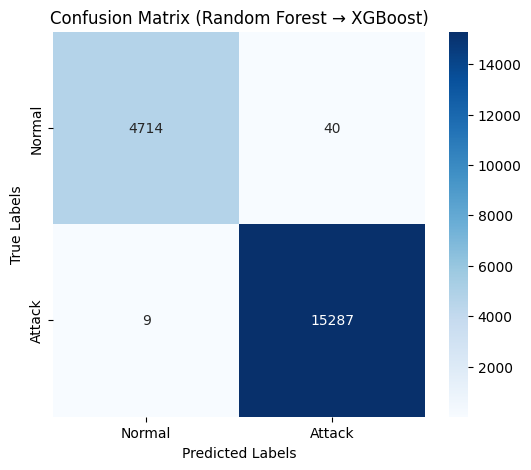

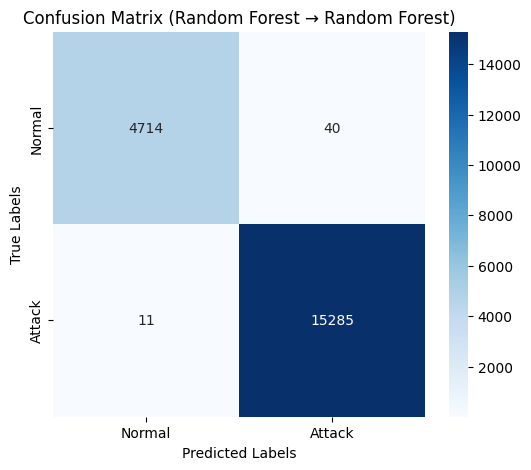

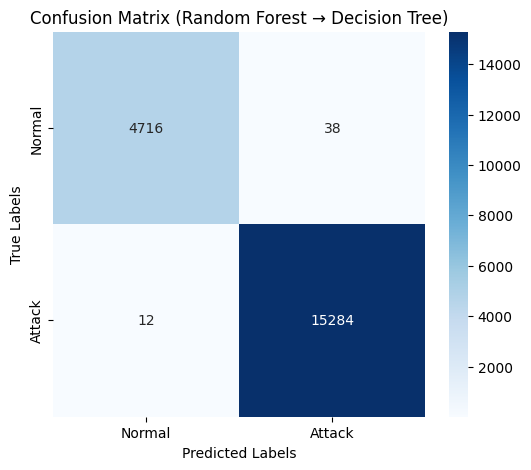

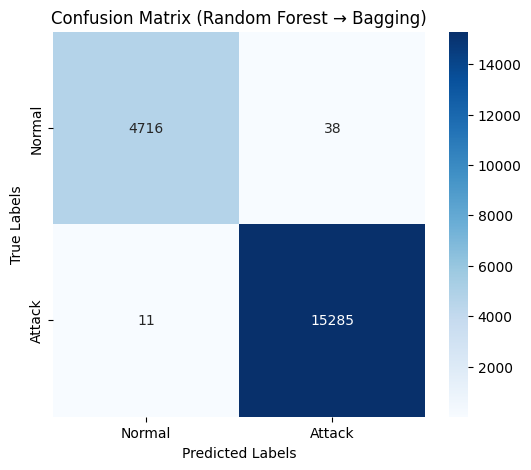

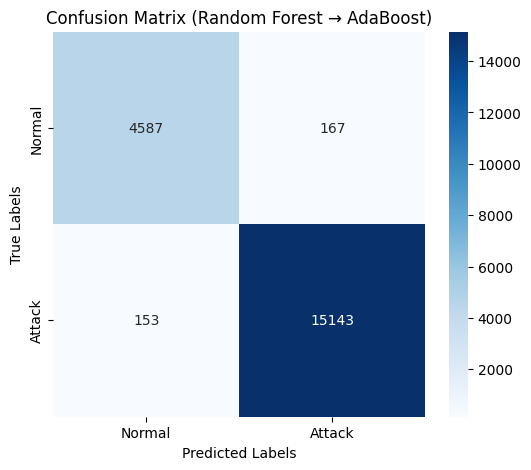

Training complete for Teacher Model: Random Forest
Results for Random Forest saved successfully!


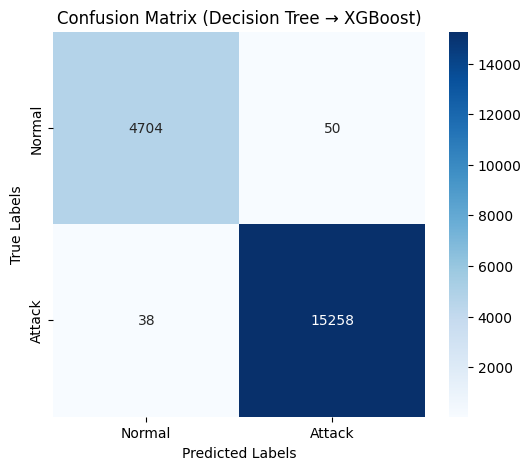

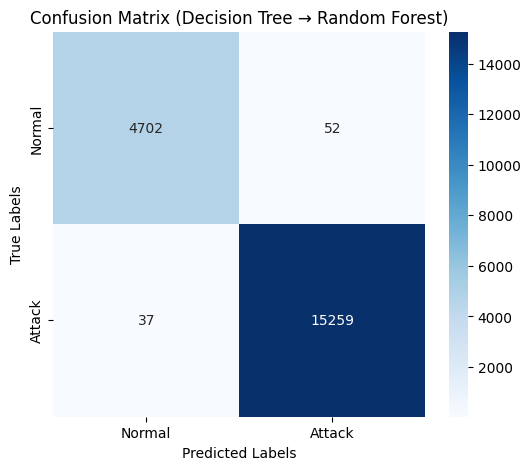

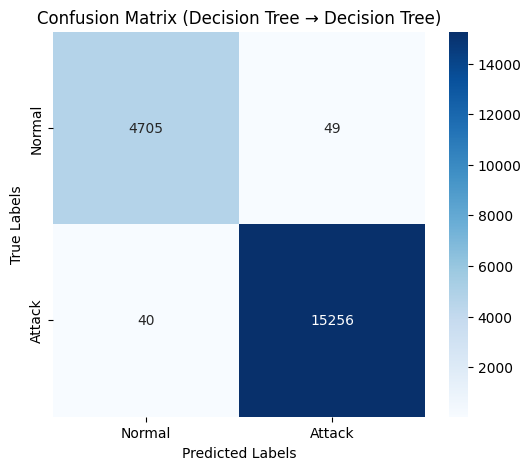

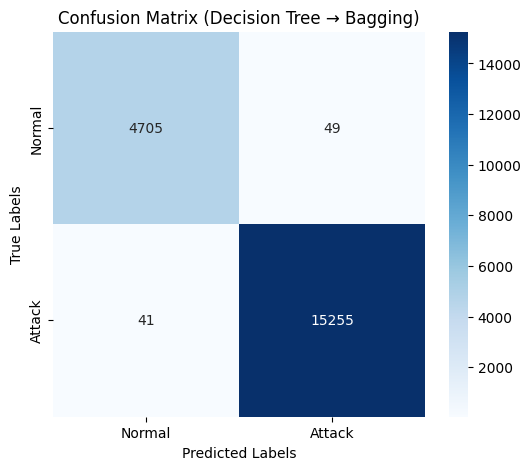

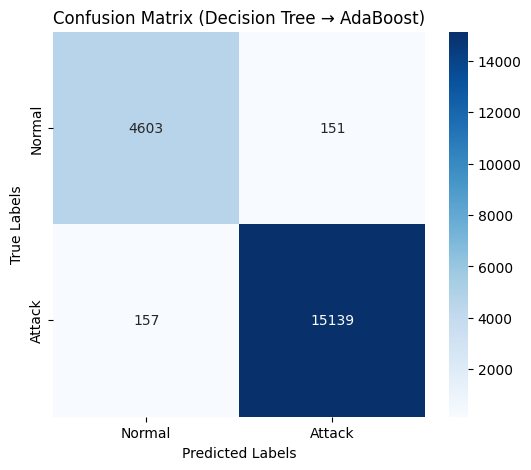

Training complete for Teacher Model: Decision Tree
Results for Decision Tree saved successfully!


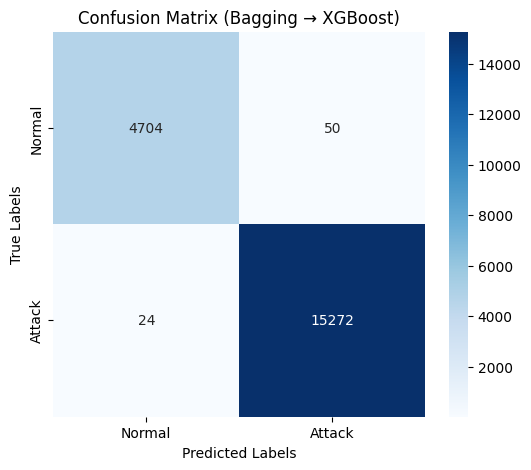

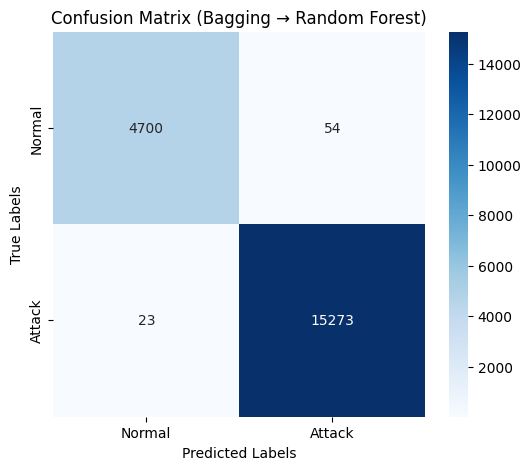

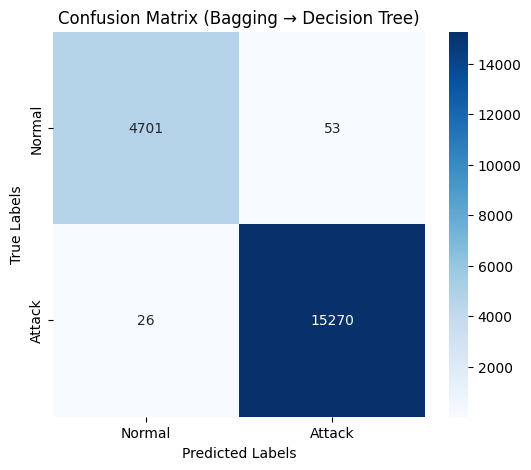

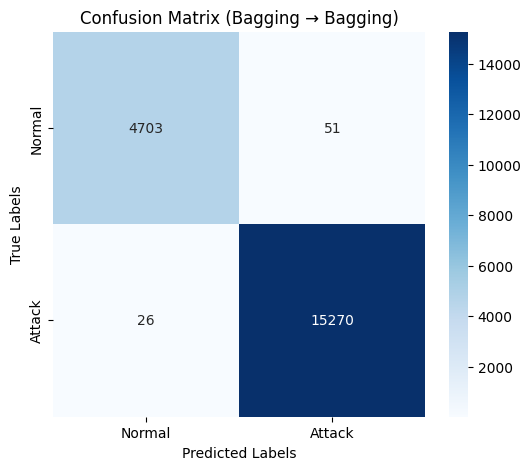

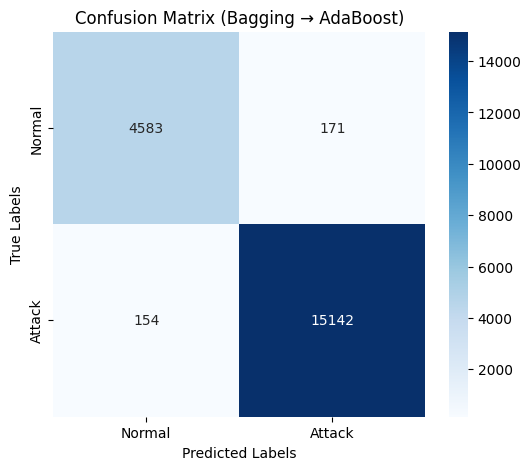

Training complete for Teacher Model: Bagging
Results for Bagging saved successfully!


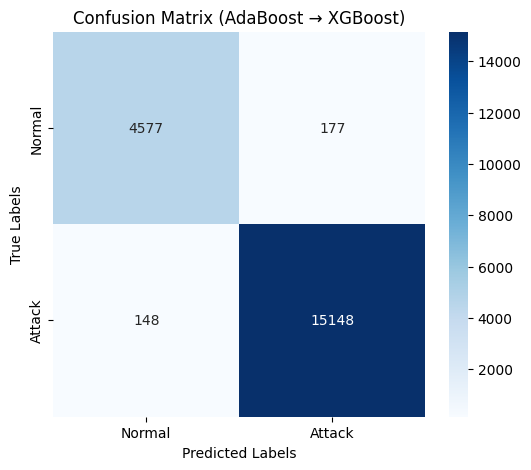

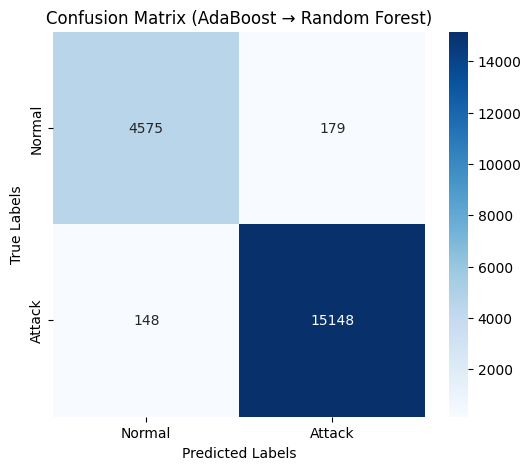

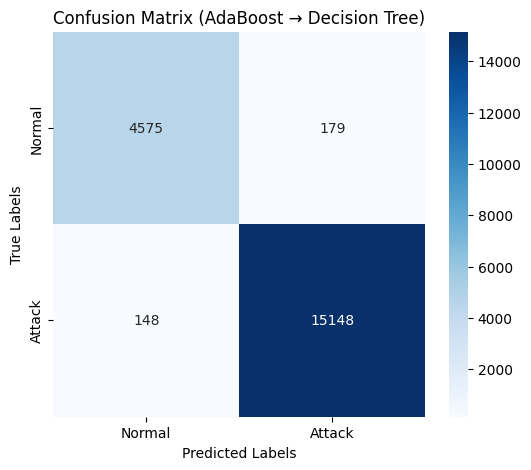

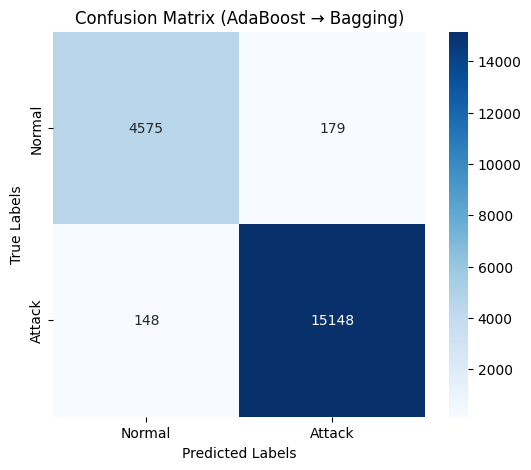

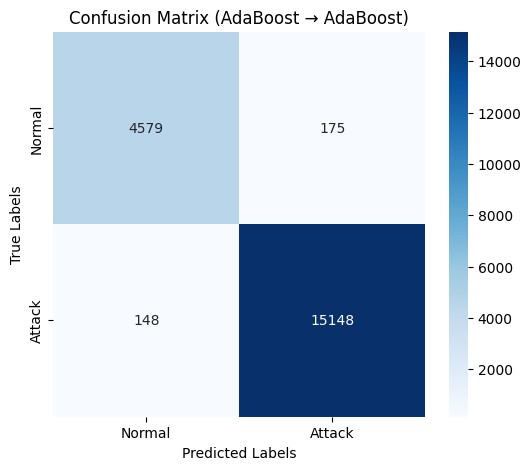

Training complete for Teacher Model: AdaBoost
Results for AdaBoost saved successfully!


In [4]:
# Main Class

# from data_handler import DataHandler
# from teacher_model import TeacherModel
# from student_model import StudentModel
import pandas as pd

# Step 1: Initialize DataHandler
data_handler = DataHandler("train_test_networkP.csv")

# Step 2: Load and split dataset
data_handler.load_dataset()
data_handler.split_labeled_unlabeled()
unlabeled_train, unlabeled_test, train_labels, test_labels = data_handler.split_unlabeled_train_test()

# Step 3: Save datasets automatically
data_handler.save_datasets()

# Step 4: Prepare labeled data for training (Train/Validation Split)
X_train, X_val, y_train, y_val = data_handler.prepare_labeled_data_for_training()

# Step 5: Train Teacher Models with 10-Fold Cross-Validation
teacher = TeacherModel(X_train, y_train)
teacher_scores = teacher.train_with_cross_validation()

# Step 6: Train Student Models with pseudo-labels from each teacher model
for teacher_model_name in teacher.trained_models.keys():
    # Generate pseudo labels
    pseudo_labels = teacher.generate_pseudo_labels(data_handler.unlabeled_train_df, teacher_model_name)

    # Convert pseudo labels to Series (1D data for training)
    pseudo_labels_series = pd.Series(pseudo_labels, name='pseudo_label')

    # Initialize and Train Student Models
    student_model = StudentModel(
        data_handler.unlabeled_train_df,  # Features
        pseudo_labels_series              # Pseudo Labels
    )

    # Train and evaluate the student models
    student_model.train_and_evaluate(data_handler.unlabeled_test_df, test_labels, teacher_model_name)

    student_model.save_results(teacher_model_name)

